In [111]:
!pip -q install matplotlib gym tensorflow pyvirtualdisplay imageio gym box2d pygame
!pip install "numpy<2.0" 
!pip install imageio-ffmpeg

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

  Using cached numpy-1.26.4-cp313-cp313-macosx_15_0_arm64.whl
  Attempting uninstall: numpy
    Found existing installation: numpy 2.4.1
    Uninstalling numpy-2.4.1:
      Successfully uninstalled numpy-2.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ml-dtypes 0.5.4 requires numpy>=2.1.0; python_version >= "3.13", but you have numpy 1.26.4 which is incompatible.
  Using cached imageio_ffmpeg-0.6.0-py3-none-macosx_11_0_arm64.whl.metadata (1.5 kB)
Using cached imageio_ffmpeg-0.6.0-py3-none-macosx_11_0_arm64.whl (21.1 MB)


In [112]:

import gym
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam
# Suppress deprecation warnings for cleaner output



In [113]:
import PIL.Image
import time
#from pyvirtualdisplay import Display
#deque will be our data structure for our memory buffer.
#namedtuple will be used to store the experience tuples.
import utils
from collections import deque, namedtuple

In [114]:
# Set up a virtual display to render the Lunar Lander environment.
#Display(visible=0, size=(840, 480)).start();

# Set the random seed for TensorFlow
tf.random.set_seed(utils.SEED)

In [115]:
#Hyperparameters
MEMORY_SIZE = 100_000     # size of memory buffer
GAMMA = 0.995             # discount factor
ALPHA = 1e-3              # learning rate
NUM_STEPS_FOR_UPDATE = 4  # perform a learning update every C time steps

Lunar LAnder Action Space
Do nothing = 0
Fire right engine = 1
Fire main engine = 2
Fire left engine = 3

Observation Space
Its  (𝑥,𝑦)  coordinates. The landing pad is always at coordinates  (0,0).
Its linear velocities  (𝑥˙,𝑦˙). Its angle  𝜃.
Its angular velocity  𝜃˙.
Two booleans,  𝑙 and  𝑟 , that represent whether each leg is in contact with the ground or not.

Rewards
For each step, the reward:

is increased/decreased the closer/further the lander is to the landing pad.
is increased/decreased the slower/faster the lander is moving.
is decreased the more the lander is tilted (angle not horizontal).
is increased by 10 points for each leg that is in contact with the ground.
is decreased by 0.03 points each frame a side engine is firing.
is decreased by 0.3 points each frame the main engine is firing.
The episode receives an additional reward of -100 or +100 points for crashing or landing safely respectively.

Episode Termination
The lunar lander crashes (i.e if the body of the lunar lander comes in contact with the surface of the moon).

The absolute value of the lander's  𝑥-coordinate is greater than 1 (i.e. it goes beyond the left or right border)

In [116]:
#Load the Environment
env = gym.make('LunarLander-v2')

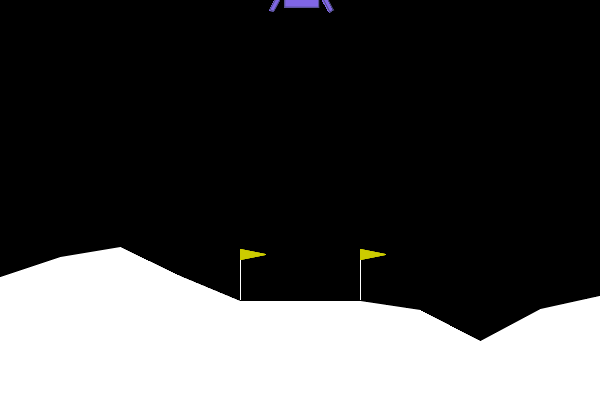

In [117]:
# 1. Define render_mode during initialization
env = gym.make("LunarLander-v2", render_mode="rgb_array")

env.reset()
PIL.Image.fromarray(env.render())

In [118]:
state_size = env.observation_space.shape
num_actions = env.action_space.n

print('State Shape:', state_size)
print('Number of actions:', num_actions)

State Shape: (8,)
Number of actions: 4


In [119]:
# Reset the environment and get the initial state.
current_state, info = env.reset()

In [120]:
# Select an action
action = 0

# --- FIX: PATCH NUMPY 2.0 FOR GYM COMPATIBILITY ---
# This manually adds 'bool8' back to NumPy so Gym doesn't crash
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_
# --------------------------------------------------
# New Gym API unpacks 5 values
next_state, reward, terminated, truncated, info = env.step(action)

# If your logic depends on 'done', combine terminated and truncated
done = terminated or truncated

# Display table with values.
utils.display_table(current_state, action, next_state, reward, done)

# Replace the `current_state` with the state after the action is taken
current_state = next_state

/Users/olaoluadisa/Documents/WEBDEV1/webdev/code files/codefiles/MLspecial/utils.py:353: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  .applymap(lambda x: 'background-color : grey' if x == '' else '')\


In practice, when we train the agent we use a loop to allow the agent to take many consecutive actions during an episode.

Deep Q-Learning

in cases where the state space is continuous it becomes practically impossible to explore the entire state-action space. Consequently, this also makes it practically impossible to gradually estimate  𝑄(𝑠,𝑎)
  until it converges to  𝑄∗(𝑠,𝑎)
 .

In the Deep  𝑄-Learning, we solve this problem by using a neural network to estimate the action-value function  𝑄(𝑠,𝑎)≈𝑄∗(𝑠,𝑎)
 . We call this neural network a  𝑄-Network and it can be trained by adjusting its weights at each iteration to minimize the mean-squared error in the Bellman equation.

     Unfortunately, using neural networks in reinforcement learning to estimate action-value functions has proven to be highly unstable. Luckily, there's a couple of techniques that can be employed to avoid instabilities. These techniques consist of using a Target Network and Experience Replay. 

1. Target Network
We can train the  𝑄-Network by adjusting it's weights at each iteration to minimize the mean-squared error in the Bellman equation.
Having a constantly moving target can lead to oscillations and instabilities. To avoid this, we can create a separate neural network for generating the  𝑦
  targets. We call this separate neural network the target  𝑄̂ -Network and it will have the same architecture as the original  𝑄-Network

every  𝐶 time steps we will use the  𝑄̂ -Network to generate the  𝑦 targets and update the weights of the target  𝑄̂ -Network using the weights of the  𝑄-Network. We will update the weights  𝑤− of the the target  𝑄̂ -Network using a soft update. By using the soft update, we are ensuring that the target values,  𝑦, change slowly, which greatly improves the stability of our learning algorithm.

In [123]:

# Create the Q-Network
q_network = Sequential([
    
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
 
    ])

# Create the target Q^-Network
target_q_network = Sequential([
    
    Input(shape=state_size),
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_actions, activation='linear')
 
    ])


optimizer = Adam(learning_rate=ALPHA)


2. Experience Replay
When an agent interacts with the environment, the states, actions, and rewards the agent experiences are sequential by nature. If the agent tries to learn from these consecutive experiences it can run into problems due to the strong correlations between them. To avoid this, we employ a technique known as Experience Replay to generate uncorrelated experiences for training our agent. Experience replay consists of storing the agent's experiences (i.e the states, actions, and rewards the agent receives) in a memory buffer and then sampling a random mini-batch of experiences from the buffer to do the learning.

By using experience replay we avoid problematic correlations, oscillations and instabilities. In addition, experience replay also allows the agent to potentially use the same experience in multiple weight updates, which increases data efficiency.

In [122]:
# Store experiences as named tuples
experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

In [124]:

def compute_loss(experiences, gamma, q_network, target_q_network):
    """
    Calculates the loss.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.
      q_network: (tf.keras.Sequential) Keras model for predicting the q_values
      target_q_network: (tf.keras.Sequential) Keras model for predicting the targets

    Returns:
      loss: (TensorFlow Tensor(shape=(0,), dtype=int32)) the Mean-Squared Error between
            the y targets and the Q(s,a) values.
    """

    # Unpack the mini-batch of experience tuples
    states, actions, rewards, next_states, done_vals = experiences

    # Compute max Q^(s,a)
    max_qsa = tf.reduce_max(target_q_network(next_states), axis=-1)

    # Set y = R if episode terminates, otherwise set y = R + γ max Q^(s,a).
    ### START CODE HERE ###
    y_targets = rewards + (gamma * max_qsa * (1 - done_vals))
    ### END CODE HERE ###

    # Get the q_values and reshape to match y_targets
    q_values = q_network(states)
    q_values = tf.gather_nd(q_values, tf.stack([tf.range(q_values.shape[0]),
                                                tf.cast(actions, tf.int32)], axis=1))

    # Compute the loss
    ### START CODE HERE ###
    loss = MSE(y_targets, q_values)
    ### END CODE HERE ###

    return loss

In [125]:
@tf.function
def agent_learn(experiences, gamma):
    """
    Updates the weights of the Q networks.

    Args:
      experiences: (tuple) tuple of ["state", "action", "reward", "next_state", "done"] namedtuples
      gamma: (float) The discount factor.

    """

    # Calculate the loss
    with tf.GradientTape() as tape:
        loss = compute_loss(experiences, gamma, q_network, target_q_network)

    # Get the gradients of the loss with respect to the weights.
    gradients = tape.gradient(loss, q_network.trainable_variables)

    # Update the weights of the q_network.
    optimizer.apply_gradients(zip(gradients, q_network.trainable_variables))

    # update the weights of target q_network
    utils.update_target_network(q_network, target_q_network)

In [ ]:
#Train the Agent

In [ ]:
start = time.time()

num_episodes = 2000
max_num_timesteps = 1000

total_point_history = []

num_p_av = 100    # number of total points to use for averaging
epsilon = 1.0     # initial ε value for ε-greedy policy

# Create a memory buffer D with capacity N
memory_buffer = deque(maxlen=MEMORY_SIZE)

# Set the target network weights equal to the Q-Network weights
target_q_network.set_weights(q_network.get_weights())

for i in range(num_episodes):

    # Reset the environment to the initial state and get the initial state
    state, _ = env.reset()
    total_points = 0

    for t in range(max_num_timesteps):

        # From the current state S choose an action A using an ε-greedy policy
        state_qn = np.expand_dims(state, axis=0)  # state needs to be the right shape for the q_network
        q_values = q_network(state_qn)
        action = utils.get_action(q_values, epsilon)

        # Take action A and receive reward R and the next state S'
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Store experience tuple (S,A,R,S') in the memory buffer.
        # We store the done variable as well for convenience.
        memory_buffer.append(experience(state, action, reward, next_state, done))

        # Only update the network every NUM_STEPS_FOR_UPDATE time steps.
        update = utils.check_update_conditions(t, NUM_STEPS_FOR_UPDATE, memory_buffer)

        if update:
            # Sample random mini-batch of experience tuples (S,A,R,S') from D
            experiences = utils.get_experiences(memory_buffer)

            # Set the y targets, perform a gradient descent step,
            # and update the network weights.
            agent_learn(experiences, GAMMA)

        state = next_state.copy()
        total_points += reward

        if done:
            break

    total_point_history.append(total_points)
    av_latest_points = np.mean(total_point_history[-num_p_av:])

    # Update the ε value
    epsilon = utils.get_new_eps(epsilon)

    print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}", end="")

    if (i+1) % num_p_av == 0:
        print(f"\rEpisode {i+1} | Total point average of the last {num_p_av} episodes: {av_latest_points:.2f}")

    # We will consider that the environment is solved if we get an
    # average of 200 points in the last 100 episodes.
    if av_latest_points >= 200.0:
        print(f"\n\nEnvironment solved in {i+1} episodes!")
        q_network.save('lunar_lander_model.h5')
        break

tot_time = time.time() - start

print(f"\nTotal Runtime: {tot_time:.2f} s ({(tot_time/60):.2f} min)")

Episode 100 | Total point average of the last 100 episodes: -155.81
Episode 200 | Total point average of the last 100 episodes: -95.188
Episode 234 | Total point average of the last 100 episodes: -75.30

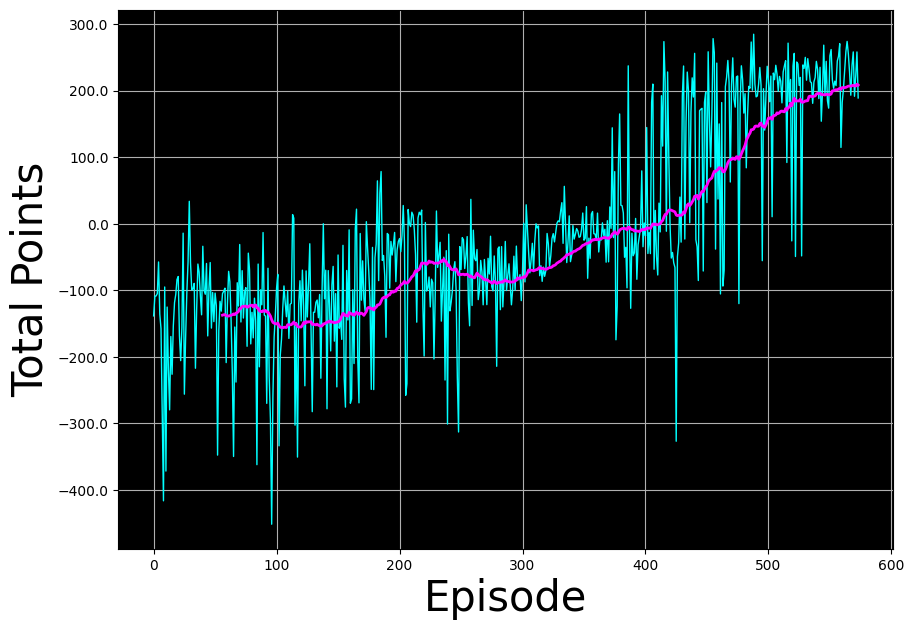

In [126]:
# Plot the total point history along with the moving average
utils.plot_history(total_point_history)

See the Trained Agent In Action

In [127]:
# Suppress warnings from imageio
import logging
logging.getLogger().setLevel(logging.ERROR)

In [129]:
import imageio


def create_video(filename, env, q_network, fps=30):
    with imageio.get_writer(filename, fps=fps) as video:
        done = False
        # FIX 1: Unpack the tuple from reset()
        state, _ = env.reset() 
        frame = env.render()
        video.append_data(frame)
        
        while not done:
            state = np.expand_dims(state, axis=0)
            q_values = q_network(state)
            action = np.argmax(q_values.numpy()[0])
            
            # FIX 2: Unpack 5 values from step()
            state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            
            frame = env.render()
            video.append_data(frame)

# Now run the code with the updated function
filename = "./videos/lunar_lander.mp4"
create_video(filename, env, q_network)
utils.embed_mp4(filename)